In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten as flat_layer, BatchNormalization as batch_norm
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D as conv_layer ,Conv2DTranspose as cov_trans
from tensorflow.keras.models import Sequential as seq, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

import warnings as warns
warns.filterwarnings('ignore')

In [ ]:
## Since the code is performed on google colab the shared drive was conneted for accessing the binary and pickle files of the dataset
from google.colab import drive
drive.mount('/content/drive')

In [2]:
DATA_PATH = '/content/'
##Training_path = '/content/drive/My Drive/Logos_dataset/logos_60k_64_64.npy'
EPOCHS = 100

In [ ]:
final_dataset.shape 

(34096, 64, 64, 3)

In [3]:
## Paths defined for cartoon dataset with 30k and 60k Dataset 
cartoon_30k = '/content/drive/My Drive/Cartoon_binary_files/cartoon_data_file_30k'
cartoon_60k = '/content/drive/My Drive/Cartoon_binary_files/cartoon_data_file_60k'

### path defined for Logos dataset with 30k and 60k 

logos_30k =  '/content/drive/My Drive/Logos_dataset/logos_30k_64_64.npy'
logos_60k =  '/content/drive/My Drive/Logos_dataset/logos_60k_64_64.npy'

In [4]:
## select the dataset and slice for performing the experiment : 
in_dataset = 'Logo' ## logo cartoon
in_datasize = '60'

In [5]:
#### Code to open the saved data in colab for importing the pre-processed data

if in_dataset == 'Logo' and in_datasize == '30':
  data_path = logos_30k
elif in_dataset == 'Logo' and in_datasize == '60':
  data_path = logos_60k
elif in_dataset == 'cartoon' and in_datasize == '30':
  data_path =cartoon_30k
elif in_dataset == 'cartoon' and in_datasize == '60':
  data_path =cartoon_60k


In [6]:
data_path

'/content/drive/My Drive/Logos_dataset/logos_60k_64_64.npy'

In [11]:
final_dataset.shape

(60632, 64, 64, 3)

In [10]:
if in_dataset == 'Logo':
  final_dataset = np.load(data_path)
else:
  import pickle
  input_file = open(data_path,'rb')
  final_dataset = pickle.load(input_file)
  input_file.close()
print("Data set loaded")

Data set loaded


In [12]:
## Give the required Shape for Input and Hyper paramters 
input_shape = (64, 64, 3 )
latent_space = 150
batch_size = 256
# Data & model configuration
img_width, img_height = 64, 64
num_channels = 3

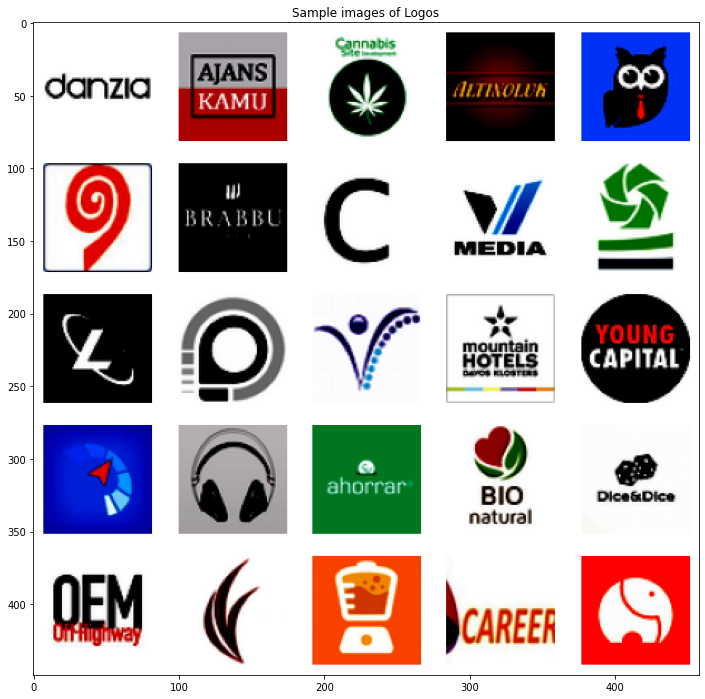

In [19]:
## Image generated using 30k Dataset sample :

fig= plt.figure(figsize=(20,12))

img=mpimg.imread('/content/Logos_images.png')
imgplot = plt.imshow(img)
plt.title("Sample images of Logos")
plt.show()

In [20]:
# Import required libraries
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from matplotlib import pyplot
from numpy.random import randn
from keras.utils.vis_utils import plot_model 
## Not working in Jupyiter:will work on Colab

In [21]:
## Define the paramters 
disc_padding = 'same'
disc_stide= (2,2)
disc_kernel =(3,3)
disc_activation_function ='sigmoid'
disc_drop = 0.4
disc_learning_rate=0.0002
disc_beta_value=0.5
disc_loss = 'binary_crossentropy'
latent_space = 150
no_samples = 49

In [22]:

# create discriminator model with multiple layers, 1-Sequential , Convoluational layer with filter 64,kernal size 3 (Logos), and 4 for Cartoon
### Leaky Relu layer, Downsampling done using Convolutional layer 
def create_discriminator_model(in_shape=input_shape):
    disc_model = seq()
 
    disc_model.add(conv_layer(64,
                              disc_kernel,
                              padding=disc_padding,
                              input_shape=in_shape))
    disc_model.add(LeakyReLU(alpha=0.2))
 ## Down sampling
    disc_model.add(conv_layer(128,
                              disc_kernel,
                              strides=disc_stide,
                              padding=disc_padding))
    disc_model.add(LeakyReLU(alpha=0.2))

    disc_model.add(conv_layer(128,
                              disc_kernel, 
                              strides=disc_stide, 
                              padding=disc_padding))
    disc_model.add(LeakyReLU(alpha=0.2))

    disc_model.add(conv_layer(256,
                              disc_kernel,
                              strides= disc_stide,
                              padding=disc_padding))
    disc_model.add(LeakyReLU(alpha=0.2))

    disc_model.add(flat_layer())
    disc_model.add(Dropout(disc_drop))
    disc_model.add(Dense(1, 
                         activation=disc_activation_function))

    opt = Adam(lr=disc_learning_rate,
               beta_1=disc_beta_value)
    ####opt = Adam(lr=0.0003, beta_1=0.9)
    disc_model.compile(loss=disc_loss,
                       optimizer=opt,
                       metrics=['accuracy'])
    return disc_model


In [23]:
# call the create discriminator
disc_model = create_discriminator_model()

In [24]:

def final_data_load():
    transformed_data = final_dataset.astype('float32')
    scale_data = (X - 127.5) / 127.5
    return scale_data


In [25]:
if in_dataset == 'Logo':
    out_channel = 3
else:
    out_channel =4
    

In [26]:
gen_relu = 0.2
gen_stride = (2,2)
gen_pad = 'same'
gen_ker = (4,4)
gen_act_fnct ='tanh'

In [27]:
# generator model
def Create_generator_model(latent_space):
    generator_model = seq()
     
    no_of_nodes = 256 * 4 * 4
    generator_model.add(Dense(no_of_nodes, input_dim=latent_space))
    generator_model.add(LeakyReLU(alpha=gen_relu))
    generator_model.add(Reshape((4, 4, 256)))
 
    generator_model.add(cov_trans(128,
                                  gen_ker,
                                  strides=gen_stride,
                                  padding=gen_pad))
    generator_model.add(LeakyReLU(alpha=gen_relu))
    ###generator_model.add(LeakyReLU(alpha=0.3))  , tried aplha 0.3
    
    generator_model.add(cov_trans(128,
                                        gen_ker, 
                                        strides=gen_stride, 
                                        padding=gen_pad))
    generator_model.add(LeakyReLU(alpha=0.2))
    ###generator_model.add(LeakyReLU(alpha=0.3))  , tried aplha 0.3
    generator_model.add(cov_trans(128,
                                        gen_ker,
                                        strides=gen_stride,
                                        padding=gen_pad))
    generator_model.add(LeakyReLU(alpha=gen_relu))
  ### for  64 , 64 , 3/4
    generator_model.add(cov_trans(128,
                                        gen_ker,
                                        strides=gen_stride,
                                        padding=gen_pad))
    generator_model.add(LeakyReLU(alpha=gen_relu))
    ##generator_model.add(LeakyReLU(alpha=0.3))  , tried aplha 0.3
    # output layer
    generator_model.add(conv_layer(out_channel, (3,3), activation=gen_act_fnct, padding=gen_pad))
    return generator_model

In [28]:
# define the discriminator model
generator_model = Create_generator_model(latent_space)

In [29]:
#### Defining loss and learning rate 
combined_loss_fnt ='binary_crossentropy'
comb_learning_rate =  0.0002
comb_beta =0.5

In [30]:
## Creating an combined model 
def combined_model():
    disc_model.trainable = False 
    disc_gen_model = seq()
    disc_gen_model.add(generator_model)
    disc_gen_model.add(disc_model)
    opt = Adam(lr=comb_learning_rate, beta_1=comb_beta)
    disc_gen_model.compile(loss=combined_loss_fnt, optimizer=opt)
    return disc_gen_model

In [31]:
disc_gen_model = combined_model()

In [32]:
epochs = 50
batch_size = 256   ##128
real = np.ones(shape=(batch_size, 1)) 
fake = np.zeros(shape=(batch_size, 1)) 

In [33]:
# Code to save plots 
def save_plot(in_data, no_of_epochs):
    no_imgs = 49
    no_count =7
## Scaling 
    in_data = (in_data + 1) / 2.0
    for img in range(no_imgs):
         pyplot.subplot(no_count, no_count, 1 + img)
         pyplot.imshow(in_data[img])
 # save plot to file into google colab files 
    images_plot = 'logos_output_60k_e%03d.png' % (no_of_epochs+1)
    pyplot.savefig(images_plot)
    pyplot.close()

In [34]:
# Define paramterters of evaluation of the models 
in_dataset =final_dataset
num_samples = 150

In [35]:
# Evaluate the performance of the models 
## We need to prepare real samples 
## Then evaluate this paramters on disciminator
## generate fake samples using Randin and sample space 
## generate fake class labels as 0 
## Again evaluate discriminator on fake samples

In [40]:
def GAN_perfomance(no_epoch, gen_model, disc_model):
    
    ix_real = randint(0, in_dataset.shape[0], num_samples)
    ix_real = in_dataset[ix_real]
    iy_real = ones((num_samples, 1))
    _, real_acc = disc_model.evaluate(ix_real, iy_real, verbose=0)
    fake_x = randn(latent_space * num_samples)
    fake_x =  fake_x.reshape(num_samples, latent_space)
    fake_x =  gen_model.predict(fake_x)
    # generate 'fake' class labels (0)
    fake_y = zeros((num_samples, 1))
    _, fake_acc = disc_model.evaluate(fake_x, fake_y, verbose=0)
    # summarize discriminator performance
    print('>Real Acc: %.0f%%, Fake value : %.0f%%' % (real_acc*100, fake_acc*100))
    # save plot
    save_plot(fake_x, no_epoch)
    # save the generator model tile file
    model_name = 'models_generated_%03d.h5' % (no_epoch+1)
    gen_model.save(model_name)

In [41]:
## Loss for generator and discriminator 
loss_disc_plot = []
loss_g_d_plot = []

In [42]:
def generate_latent_points(latent_space, no_of_samples):
	inp_value = randn(latent_space * no_of_samples)
	inp_value = inp_value.reshape(no_of_samples, latent_space)
	return inp_value

In [44]:
# train the generator and discriminator
def train(dataset, latent_dim, n_epochs=150, n_batch=256):
    epochs_per_batch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
 
 # manually enumerate epochs
    for epochs_i in range(n_epochs):
        for j in range(epochs_per_batch):
            ##X_real = dataset[i*batch_size:(i+1)*batch_size]
            ix_real = randint(0, dataset.shape[0], half_batch)
            x_real = dataset[ix_real]
            y_real = ones((half_batch, 1))
            d_loss1, _ = disc_model.train_on_batch(x_real, y_real)
            x_input = generate_latent_points(latent_dim, half_batch)
            X_fake1 = generator_model.predict(x_input)
            yfake1 = zeros((half_batch, 1))
	          
            d_loss2, _ = disc_model.train_on_batch(X_fake1, yfake1)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
             
            g_loss = disc_gen_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, Disc_loss_1=%.3f, Loss_d2=%.3f gen=%.3f' %
                      (epochs_i+1, j+1, epochs_per_batch, d_loss1, d_loss2, g_loss))
            loss_disc_plot.append(d_loss1)
            loss_g_d_plot.append(g_loss)
  
        if (epochs_i+1) % 15 == 0:  ### 15 for 150 epochs and 20 for 200 epochs
          GAN_perfomance(epochs_i, generator_model, disc_model)

In [ ]:
# train model
train(final_dataset, latent_space )

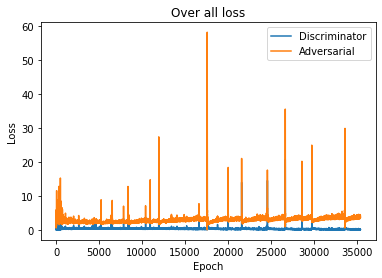

In [48]:
## simple plot of losses during the training for Discriminator and Generator losses 
pyplot.plot(loss_disc_plot)
pyplot.plot(loss_g_d_plot)
pyplot.title('Over all loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Discriminator', 'Adversarial'])
pyplot.show()

In [ ]:
'''Results ploted :since these where generated and saved during training : here just the images geneated are dislayed for 
   Cartoon dataset : 30k slice , epochs 200 , batch size : 128 
   Cartoon dataset : 60k Slice , epochs 150 , batch size : 256
   Logos : 30k slice, epochs 200 , batch size : 128
   logos : 60k slice , epochs 150 , batch size : 256
'''

Populating the interactive namespace from numpy and matplotlib


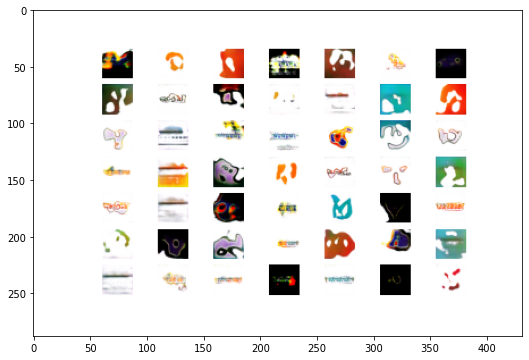

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig= plt.figure(figsize=(10,6))

img=mpimg.imread('/content/images_cartoon_64_64_4_e100.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
## Code for Displaying cartoon images generated using the model 
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

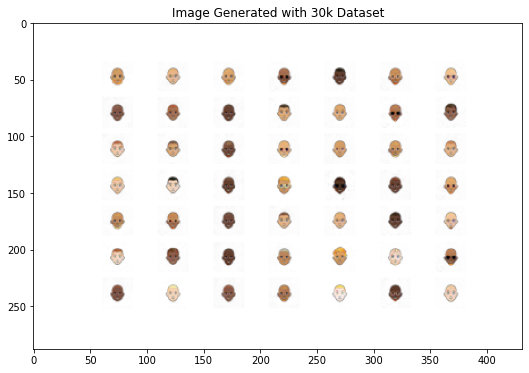

In [ ]:
## Image generated using 30k Dataset sample :

fig= plt.figure(figsize=(10,6))

img=mpimg.imread('/content/Cartoon_output_30k_epoch_150.png')
imgplot = plt.imshow(img)
plt.title("Image Generated with 30k Dataset")
plt.show()

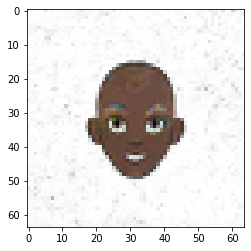

In [ ]:
## Import model which was generated during training to Generate new image using latent space
model = load_model('models_generated_150.h5')
gen_vec = asarray([[0.30 for _ in range(100)]])
gen_image = model.predict(gen_vec)
gen_image = (gen_image + 1) / 2.0
pyplot.imshow(gen_image[0, :, :])
pyplot.show()

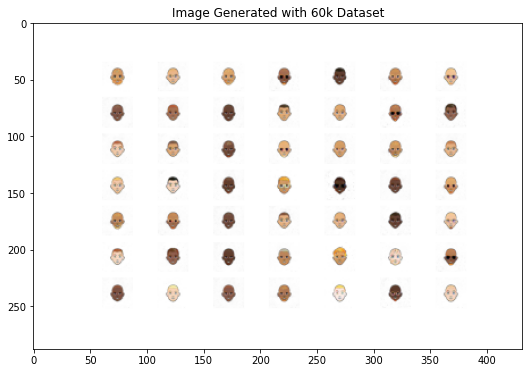

In [ ]:
## Image generated using 60k Dataset sample :

fig= plt.figure(figsize=(10,6))

img=mpimg.imread('/content/Cartoon_output_60k_epoch_150.png')
imgplot = plt.imshow(img)
plt.title("Image Generated with 60k Dataset")
plt.show()

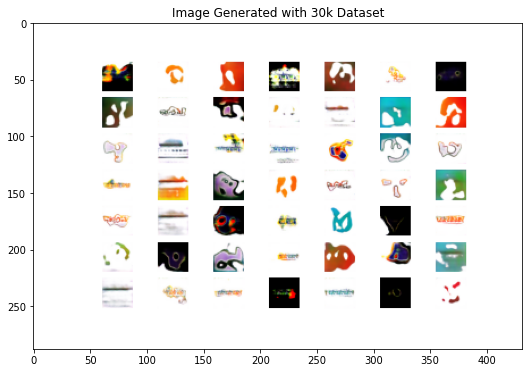

In [ ]:
## Image generated using 30k Logos Dataset sample :

fig= plt.figure(figsize=(10,6))

img=mpimg.imread('/content/logos_output_30k_epoch_200.png')
imgplot = plt.imshow(img)
plt.title("Image Generated with 30k Dataset")
plt.show()

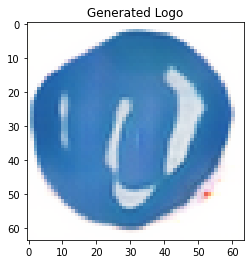

In [ ]:

## Logo generated from the saved model 
model = load_model('/content/logos_model_60k_epoch_150.h5')

sample_vector = asarray([[0.30 for _ in range(100)]])

gen_image = model.predict(sample_vector)

gen_image = (gen_image + 1) / 2.0
pyplot.title("Generated Logo")
pyplot.imshow(gen_image[0, :, :])
pyplot.show()

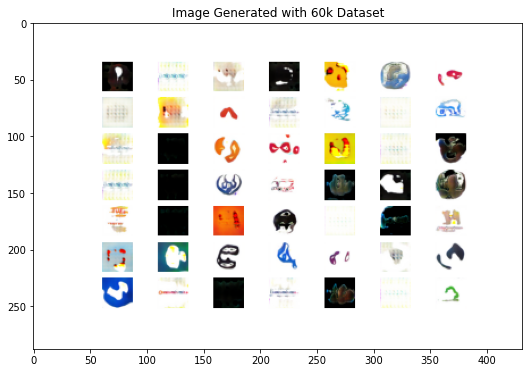

In [ ]:
## Image generated using 60k Logos Dataset sample :

fig= plt.figure(figsize=(15,6))

img=mpimg.imread('/content/logos_output_60k_epoch_150.png')
imgplot = plt.imshow(img)
plt.title("Image Generated with 60k Dataset")
plt.show()


In [ ]:
### Code used to Save the colab file as HTML document since, it does not have in-built option to save as  html file 
!jupyter nbconvert --to html GAN_image_generation_code.ipynb

[NbConvertApp] Converting notebook GAN_image_generation_code.ipynb to html
[NbConvertApp] Writing 1379670 bytes to GAN_image_generation_code.html
